In [1]:
import json
import math
import pytz
from datetime import datetime,timedelta,timezone
from dateutil.tz import tzutc
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import csv
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode,skew,kurtosis
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from scipy.interpolate import UnivariateSpline
from sklearn.utils.multiclass import type_of_target

addDataPrefix='/Users/sorush/My Drive/Documents/Educational/TAMU/Research/Trial/Data/11-5-21-11-15-21'
if not os.path.exists(addDataPrefix):
    addDataPrefix='/home/grads/s/sorush.omidvar/CGMDataset/Trial/Data/11-5-21-11-15-21'
addUserInput=os.path.join(addDataPrefix,'User inputted')
addHKCM=os.path.join(addDataPrefix,'hk+cm')
addCGM=os.path.join(addDataPrefix,'CGM')
addE4=os.path.join(addDataPrefix,'E4')

exempts=['p2']

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)

In [2]:
START_OF_TRIAL = datetime.strptime('11 06 2021-02:00:00', '%m %d %Y-%H:%M:%S')#to handle the daylight saving issue in apple watches
END_OF_TRIAL = datetime.strptime('11 15 2021-00:00:00', '%m %d %Y-%H:%M:%S')  

if os.path.exists(os.path.join(addDataPrefix,'All_meals.pkl')):
    os.remove(os.path.join(addDataPrefix,'All_meals.pkl'))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addDataPrefix,'All_meals.pkl')):    
    df=[]
    for root, dirs, files in os.walk(addUserInput):
        for file in files:
            if '.csv' in file.lower():
                if 'meals' in file.lower():
                    participantName=file[:file.find('Meals')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0,'Participant',participantName)
                    dfTemp.rename(columns={'startTime':'StartTime'}, inplace=True)
                    dfTemp['StartTime']=pd.to_datetime(dfTemp['StartTime'])
                    dfTemp['FinishTime']=pd.to_datetime(dfTemp['FinishTime'])

                    dfTemp['StartTime']-=pd.DateOffset(hours=5)#fixing the time zone issue
                    dfTemp['FinishTime']-=pd.DateOffset(hours=5)#fixing the time zone issue            
                    dfTemp.sort_values(["Participant",'StartTime'],ascending = (True, True),inplace=True)
                    if len(dfTemp.columns)!=10:
                        print("MAYDAY. Error in reading csv")
                        break
                    if len(df)!=0:
                        frames=[dfTemp,df]
                        df=pd.concat(frames)
                    else:
                        df=dfTemp
    print("reading is done")
    dfMeal=df    
    dfMeal=dfMeal[dfMeal['StartTime']>=START_OF_TRIAL]
    dfMeal=dfMeal[dfMeal['FinishTime']<END_OF_TRIAL]
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addDataPrefix,'All_meals.pkl')) 
else:
    dfMeal=pd.read_pickle(os.path.join(addDataPrefix,'All_meals.pkl'))

def pdInterpolation(dfTemp):
    index=dfTemp['Time']
    seriesParticipant = pd.Series(dfTemp['Abbot'].to_list(), index=index)
    seriesParticipant=seriesParticipant.resample('1T').asfreq()
    seriesParticipant.interpolate(method='polynomial',order=3,inplace=True)
    tempTime=seriesParticipant.index
    tempVal=seriesParticipant.values
    dfTemp=pd.DataFrame(zip(tempTime,tempVal),columns=['Time','Abbot'])
    return dfTemp

if os.path.exists(os.path.join(addDataPrefix,'All_cgm.pkl')):
    os.remove(os.path.join(addDataPrefix,'All_cgm.pkl'))
if not os.path.exists(os.path.join(addDataPrefix,'All_cgm.pkl')):
    os.chdir(addCGM)
    dfCGM=[]
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if '.txt' in file.lower():
                if '_fl' in file.lower():
                    participantName=file[:file.find('_fl')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp = pd.read_csv(file,sep="\t",skiprows=1)
                    if len(dfTemp.columns)!=4:
                        print("MAYDAY. Error in reading csv")
                        break               
                    dfTemp.columns.values[0] = "ID"
                    dfTemp.columns.values[1] = "Time"
                    dfTemp.columns.values[2] = "Record"
                    dfTemp.columns.values[3] = "Abbot"
                    dfTemp.drop(columns=["ID",'Record'],inplace=True)                
                    dfTemp['Time']=pd.to_datetime(dfTemp['Time'])
                    dfTemp['Abbot']=pd.to_numeric(dfTemp['Abbot'])
                    dfTemp.sort_values(["Time"],ascending = (True),inplace=True)
                    dfTemp=pdInterpolation(dfTemp)
                    dfTemp.insert(0,'Participant',participantName)
                    if len(dfTemp.columns)!=3:
                        print("MAYDAY. Error in processing csv")
                        break                    
                    if len(dfCGM)!=0:
                        frames=[dfTemp,dfCGM]
                        dfCGM=pd.concat(frames)
                    else:
                        dfCGM=dfTemp
    print("reading is done")
    dfCGM=dfCGM[dfCGM['Time']>=START_OF_TRIAL]
    dfCGM=dfCGM[dfCGM['Time']<END_OF_TRIAL]
    print("CGM database is limited to the trial period")
    dfCGM.to_pickle(os.path.join(addDataPrefix,'All_cgm.pkl')) 
else:
    dfCGM=pd.read_pickle(os.path.join(addDataPrefix,'All_cgm.pkl'))


  
# if os.path.exists(os.path.join(addDataPrefix,'All_cm.pkl')):
#     os.remove(os.path.join(addDataPrefix,'All_cm.pkl'))
os.chdir(addHKCM)
if not os.path.exists(os.path.join(addDataPrefix,'All_cm.pkl')):
    df=[]
    for root, dirs, files in os.walk(addHKCM):
        for file in files:
            if '.csv' in file.lower():
                if 'cm' in file.lower() and 'modified' in file.lower():
                    participantName=file[:file.find('_cm')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp=pd.read_csv(file)
                    print("File is read")
                    dfTemp['Time']=pd.to_datetime(dfTemp['Time'])
                    dfTemp.insert(0,'Participant',participantName)
                    dfTemp.insert(len(dfTemp.columns),'|Ax|+|Ay|+|Az|',dfTemp['Ax'].abs()+dfTemp['Ay'].abs()+dfTemp['Az'].abs()+0.001)#this is to avoid 0 later on for feature calculation
                    dfTemp.insert(len(dfTemp.columns),'|Yaw|+|Roll|+|Pitch|',dfTemp['Yaw'].abs()+dfTemp['Roll'].abs()+dfTemp['Pitch'].abs())
                    dfTemp.insert(len(dfTemp.columns),'RotationalToLinear',dfTemp['|Yaw|+|Roll|+|Pitch|']/dfTemp['|Ax|+|Ay|+|Az|'])
                    print("modified")
                    dfTemp.sort_values(['Time'],ascending = (True),inplace=True)
                    print("sorted")
                    if len(dfTemp.columns)!=14:
                        print("MAYDAY. Error in reading csv")
                        print(dfTemp.columns)
                        break
                    if len(df)!=0:
                        frames=[dfTemp,df]
                        df=pd.concat(frames)
                    else:
                        df=dfTemp
    dfCM=df
    print("Processing is done")
    dfCM=dfCM[dfCM['Time']>=START_OF_TRIAL]
    dfCM=dfCM[dfCM['Time']<END_OF_TRIAL]
    print("CM database is limited to the trial period")
    dfCM.to_pickle(os.path.join(addDataPrefix,'All_cm.pkl')) 
else:
    dfCM = pd.read_pickle(os.path.join(addDataPrefix,'All_cm.pkl'))


Exemption... p2Meals.csv
Reading ... p4Meals.csv
Reading ... p3Meals.csv
Reading ... p1Meals.csv
reading is done
Meal database is limited to the trial period
Reading ... p3_fl.txt
Exemption... p2_fl.txt
Reading ... p1_fl.txt
Reading ... p4_fl.txt
reading is done
CGM database is limited to the trial period


In [18]:
def motionCalculator(df):
    f1=df['RotationalToLinear'].mean()
    f2=df['|Ax|+|Ay|+|Az|'].mean()
    f5=df['|Yaw|+|Roll|+|Pitch|'].mean()
    return [f1,f2,f5]

def featureExtractor(dataList):
    dataList=np.asarray(dataList).astype(float)
    rangeVal=np.nanmax(dataList)-np.nanmin(dataList)
    meanVal=np.nanmean(dataList)
    stdVal=np.nanstd(dataList)
    minVal=np.nanmin(dataList)
    maxVal=np.nanmax(dataList)
    skewnessVal=skew(dataList,nan_policy='omit')
    kurtosisVal=kurtosis(dataList,nan_policy='omit')

    return [rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal]

MINIMUM_POINT_CM=100
OUTTER_WINDOW_LENGTH=timedelta(minutes=180)
OUTTER_WINDOW_STEP=timedelta(minutes=90)
EATING_PORTION=timedelta(minutes=90)
INNER_WINDOW_LENGTH=timedelta(minutes=1)

participants=dfCM['Participant'].to_list()
participants=list(set(participants))
participantDataList=[]
skippedWindows=0

# if os.path.exists(os.path.join(addDataPrefix,'Features.pkl')):
#     os.remove(os.path.join(addDataPrefix,'Features.pkl'))
if not os.path.exists(os.path.join(addDataPrefix,'Features.pkl')):
    for participant in participants:
        outterWindowStart=START_OF_TRIAL
        outterWindowEnd=outterWindowStart+OUTTER_WINDOW_LENGTH        
        print("Participant ",participant," is started")
        dfParticipantCM=dfCM[dfCM['Participant']==participant]
        dfParticipantMeal=dfMeal[dfMeal['Participant']==participant]
        dfParticipantCGM=dfCGM[dfCGM['Participant']==participant]
        print("CM size for participant",len(dfParticipantCM))
        innerWindowStart=outterWindowStart
        innerWindowEnd=innerWindowStart+INNER_WINDOW_LENGTH        
        for i in tqdm(range(0,int(((END_OF_TRIAL-START_OF_TRIAL).total_seconds())/(OUTTER_WINDOW_LENGTH.total_seconds())),1)):
            dfTempMeal=dfParticipantMeal[(dfParticipantMeal['StartTime']>=outterWindowStart) & (dfParticipantMeal['StartTime']<=outterWindowStart+EATING_PORTION)]
            tempList=[]
            tempListCM=[]
            tempListCGM=[]
            tempListInfo=[]
            skippedFlag=True
            for j in range(0,int((OUTTER_WINDOW_LENGTH.total_seconds())/(INNER_WINDOW_LENGTH.total_seconds())),1):
                dfTempCM=dfParticipantCM[(dfParticipantCM['Time']>=innerWindowStart) & (dfParticipantCM['Time']<innerWindowEnd)]
                if(len(dfTempCM)<MINIMUM_POINT_CM):
                    tempListCM.extend(['Nan','Nan','Nan'])
                else:
                    tempListCM.extend(motionCalculator(dfTempCM))
                    skippedFlag=False
                innerWindowStart+=INNER_WINDOW_LENGTH
                innerWindowEnd+=INNER_WINDOW_LENGTH
            tempListInfo.extend([outterWindowStart,outterWindowEnd,participant[1:]])
            if len(dfTempMeal)>0:
                mealFlag=1
            else:
                mealFlag=0
            if skippedFlag:
                skippedWindows+=1
            else:
                assert len(tempListCM)==int((OUTTER_WINDOW_LENGTH.total_seconds())/(INNER_WINDOW_LENGTH.total_seconds()))*3
                tempListCM=featureExtractor(tempListCM)
                tempList.extend(tempListCM)

                dfTempCGM=dfParticipantCGM[(dfParticipantCGM['Time']>=outterWindowStart) & (dfParticipantCGM['Time']<outterWindowEnd)]
                # print(outterWindowStart,outterWindowEnd)
                tempListCGM=dfTempCGM['Abbot'].to_list()
                tempListCGM=featureExtractor(tempListCGM)
                tempList.extend(tempListCGM)

                tempList.extend(tempListInfo)
                tempList.extend([mealFlag])
                assert len(tempList)==7*2+4
                participantDataList.append(tempList)
            outterWindowStart+=OUTTER_WINDOW_STEP
            outterWindowEnd+=OUTTER_WINDOW_STEP
    participantDataArray=np.asarray(participantDataList)
    columns=['CMRang','CMMean','CMStd','CMMin','CMMax','CMSkew','CMKurtosis','CgMRang','CGMMean','CGMStd','CGMMin','CGMMax','CGMSkew','CGMKurtosis','Start','End','Participant','MealLabel']
    dfFeatures=pd.DataFrame(participantDataArray,columns=columns)
    dfFeatures.to_pickle(os.path.join(addDataPrefix,'Features.pkl')) 
else:
    dfFeatures = pd.read_pickle(os.path.join(addDataPrefix,'Features.pkl'))


Participant  p1  is started
CM size for participant 7643165


100%|██████████| 71/71 [11:25<00:00,  9.65s/it]


Participant  p3  is started
CM size for participant 7567184


100%|██████████| 71/71 [11:24<00:00,  9.63s/it]


Participant  p4  is started
CM size for participant 7191513


100%|██████████| 71/71 [10:24<00:00,  8.79s/it]


In [12]:
a=dfCGM[dfCGM['Participant']=='p2']
a=a[a['Time'].dt.day==14]    
print(a)

Empty DataFrame
Columns: [Participant, Time, Abbot]
Index: []


With NORMALIZATION
Participant: 4
4.0 4.0 4.0


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


***********Val:
[[11  0]
 [ 2  2]]
Accuracy: 87.0 Recall: 50.0 Precision: 100.0
***********Test:
[[17  0]
 [ 1  3]]
Accuracy: 95.0 Recall: 75.0 Precision: 100.0
Participant: 3
10.0 7.0 7.0


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


***********Val:
[[6 2]
 [3 4]]
Accuracy: 67.0 Recall: 57.0 Precision: 67.0
***********Test:
[[13  2]
 [ 2  5]]
Accuracy: 82.0 Recall: 71.0 Precision: 71.0
Participant: 1
10.0 2.0 5.0


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


***********Val:
[[10  3]
 [ 0  2]]
Accuracy: 80.0 Recall: 100.0 Precision: 40.0
***********Test:
[[14  3]
 [ 0  5]]
Accuracy: 86.0 Recall: 100.0 Precision: 62.0


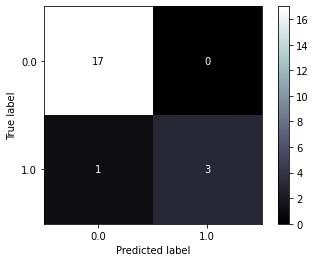

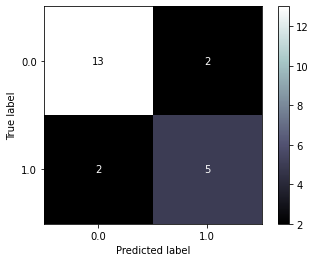

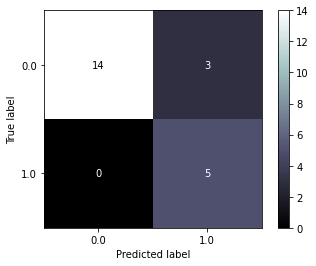

In [21]:
def STMI_XGBoost(xTrain,xVal,xTest,yTrain,yVal,yTest):
    f1ScoreBest=-1
    for maxDepth in tqdm(np.arange(1,5,1)):
        for estimator in np.arange(50,200,50):
            for threshold in np.arange(0.2,0.9,0.2):
                clf = xgb.XGBClassifier(scale_pos_weight = 10, n_jobs=18,n_estimators=estimator,max_depth=maxDepth, objective = "binary:logistic", eval_metric = "error")
                clf.fit(xTrain,yTrain)
                predictionsVal = clf.predict(xVal)
                # predictionsVal = clf.predict_proba(xVal)
                # predictionsVal=predictionsVal[:,1]
                # predictionsVal[predictionsVal>=threshold]=1
                # predictionsVal[predictionsVal<threshold]=0
                
                confMatrix=sklearn.metrics.confusion_matrix(yVal,predictionsVal)
                accuracy=sklearn.metrics.accuracy_score(yVal,predictionsVal)
                recall=sklearn.metrics.recall_score(yVal,predictionsVal)
                precision=sklearn.metrics.precision_score(yVal,predictionsVal)
                f1Score=sklearn.metrics.f1_score(yVal,predictionsVal)

                if f1Score>f1ScoreBest:
                    confMatrixBest=confMatrix
                    accuracyBest=accuracy
                    modelBest=clf
                    recallBest=recall
                    precisionBest=precision
                    thresholdBest=threshold
                    f1ScoreBest=f1Score
    print("***********Val:")
    print(confMatrixBest)
    print("Accuracy:",np.round(100*accuracyBest,0),"Recall:",np.round(100*recallBest,0),"Precision:",np.round(100*precisionBest,0))
    print("***********Test:")
    predictionsTest=modelBest.predict(xTest)
    # predictionsTest=modelBest.predict_proba(xTest)
    # predictionsTest=predictionsTest[:,1]
    # predictionsTest[predictionsTest>=thresholdBest]=1
    # predictionsTest[predictionsTest<thresholdBest]=0    
    
    confMatrix=sklearn.metrics.confusion_matrix(yTest,predictionsTest)
    accuracy=sklearn.metrics.accuracy_score(yTest,predictionsTest)
    recall=sklearn.metrics.recall_score(yTest,predictionsTest)
    precision=sklearn.metrics.precision_score(yTest,predictionsTest)
    
    print(confMatrix)
    print("Accuracy:",np.round(100*accuracy,0),"Recall:",np.round(100*recall,0),"Precision:",np.round(100*precision,0))
    plot_confusion_matrix(modelBest, xTest, yTest,cmap='bone') 

def dataBalancer(xTrain,xVal,yTrain,yVal):
    oversample = SMOTE()
    xVal, yVal = oversample.fit_resample(xVal, yVal)
    xTrain, yTrain = oversample.fit_resample(xTrain, yTrain)

    return xTrain,xVal,yTrain,yVal

def testTrainSplitFunc(data,randomSeed,normalFlag):
    #Data contains 3 CM per inner window, 1 CGM per inner window, which makes 4 point per inner window* number of inner window + [start time of outer window, end time of outer window, participant name, meal flag of outer window]
    assert data.shape[1]==7*2+4
    participants=data[:,data.shape[1]-2]
    participants=list(set(participants))
    for participant in participants:
        print("Participant:",participant)
        indxList=[]
        for counter in range(data.shape[0]):
            if(data[counter,data.shape[1]-2]==participant):
                indxList.append(counter)
        dataParticipant=data[indxList,:]

        windowStarts=dataParticipant[:,dataParticipant.shape[1]-4]
        windowEnds=dataParticipant[:,dataParticipant.shape[1]-3]
        
        dataX=dataParticipant[:,0:dataParticipant.shape[1]-4]
        dataY=dataParticipant[:,dataParticipant.shape[1]-1]
        dataY=dataY.astype(float)
        dataX=dataX.astype(float)
        random.seed(randomSeed)
        np.random.shuffle(data)
        if(normalFlag):
            dataX=dataX-dataX.mean(axis=0)
            dataX/=dataX.std(axis=0)
        
        stratidiedSampling = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
        for trainIndex, testIndex in stratidiedSampling.split(dataX, dataY):
            xTrain,xTest=dataX[trainIndex],dataX[testIndex]
            yTrain,yTest=dataY[trainIndex],dataY[testIndex]

        stratidiedSampling = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
        for trainIndex, valIndex in stratidiedSampling.split(xTrain, yTrain):
            xTrain,xVal=dataX[trainIndex],dataX[valIndex]
            yTrain,yVal=dataY[trainIndex],dataY[valIndex]
        print(np.sum(yTrain),np.sum(yVal),np.sum(yTest))
        # xTrain,xVal,yTrain,yVal=dataBalancer(xTrain,xVal,yTrain,yVal)
        STMI_XGBoost(xTrain,xVal,xTest,yTrain,yVal,yTest)


participantDataArray=dfFeatures.to_numpy()
randomSeed=random.randrange(50)

# print("Without NORMALIZATION")
# NORMALIZED_FLAG=False
# testTrainSplitFunc(participantDataArray,randomSeed,NORMALIZED_FLAG)

print("With NORMALIZATION")
NORMALIZED_FLAG=True
testTrainSplitFunc(participantDataArray,randomSeed,NORMALIZED_FLAG)